# Modelado del problema matemático en 1D

En este tutorial utilizaremos coeficientes variables, es decir, en la primer ecuación de este [link](https://github.com/rirastorza/Intro2FEM/blob/master/Elementos_finitos_en_1D/fem1D_Robin.ipynb) tanto $a$ como $f$ serán funciones de $x$. Veremos cómo hacer con FEniCS el ejemplo de la página 37 del [libro de Larson y Bengzon](https://www.springer.com/gp/book/9783642332869).

## Ejemplo con coeficientes variables 

La PDE con condiciones de borde Dirichlet y Robin que resolveremos será:

$$ \left \{ \begin{array}{l} -\underbrace{\left(0,5+0,06x\right)}_{a(x)}T^{''}= \underbrace{0,03\left(x-6\right)^{4}}_{f(x)} \ \ \text{ para } \ \ x\in I=\left(2,8 \right) \\   T(2)=7  \ \ \text{condición de borde Dirichlet} \\  T^{'}(8)= 0  \ \ \text{condición de borde Neumann} \end{array} \right .$$

La formulación variacional en este caso será:

$$\left [\int_{2}^{8}\left(0,5+0,06x\right)v^{'}T^{'}dx + T^{'}(2)v(2) - T^{'}(8)v(8)\right ] = \int_{2}^{8} \ 0,03\left(x-6\right)^{4} \ vdx \tag{1}$$

Reemplazamos las condiciones de contorno, en $x=2$ debe ser cero $v$ para poder cumplir la condición de Dirichlet, pero en $x=8$ no. Entonces quedará:

$$\int_{2}^{8}\left(0,5+0,06x\right)v^{'}T^{'}dx = \int_{2}^{8} \ 0,03\left(x-6\right)^{4} \ vdx + T^{'}(8)v(8) \tag{2}$$

Con lo visto hasta ahora podemos resolver el problema en FEniCS. Se comienza importando las librerías, definiendo los parámetros y la malla. También definimos el espacio de funciones.

In [9]:
from __future__ import print_function
from fenics import *
# Defino la malla
nx = 25 #numero de intervalos
minx, maxx = 2.0, 8.0 
mesh = IntervalMesh(nx, minx, maxx)#malla en 1D 
V = FunctionSpace(mesh, 'CG',1)#Continuous Lagrange elements


En el código siguiente se definen las clases que nos indican dónde se aplicarán las condiciones de borde. 

In [10]:
def borde_iz(x, on_boundary):
    tol = 1.E-14
    return on_boundary and near(x[0], 2., tol)

class borde_der(SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and near(x[0], 8, tol)

bc_iz = DirichletBC(V, Constant(7.0), borde_iz)
bc = [bc_iz]

#Función de la malla con parámetro que indica la topología
marcadores_bordes = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
bcder = borde_der()
bcder.mark(marcadores_bordes, 20)
#Defino el subdominio de los bordes
ds = Measure('ds', domain=mesh, subdomain_data=marcadores_bordes)

Ahora hacemos las funciones que representan $a(x)$ y $f(x)$.

In [11]:
u = TrialFunction(V)
v = TestFunction(V)

class funcion_a(UserExpression):
    def eval(self, values, x):
        values[0] = (.5-0.06*x[0])
    def value_shape(self):
        return ()

class funcion_f(UserExpression):
    def eval(self, values, x):
        values[0] = 0.03*pow(x[0]-6,4)
    def value_shape(self):
        return ()
    
a = funcion_a()
f = funcion_f()
g = 0.0#a*p*q


Noten que las funciones las derivamos de la clase UserExpression, y aquí adentro se pasan las funciones. Luego solo queda pasar la función bilineal y lineal, resolver, y graficar.

Tipo de variable: <class 'dolfin.function.function.Function'>
Cantidad de celdas: 25
Cantidad de vertices: 26


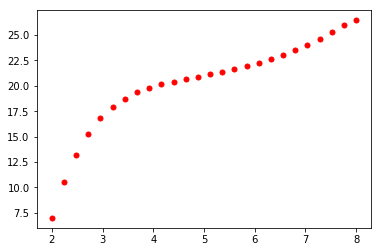

In [12]:
#Definicion abstracta 
a_bilineal = dot(a*grad(u), grad(v))*dx#-a*p*u*v*ds(20)
L_lineal = f*v*dx+g*v*ds(20)

# Resuelvo
u = Function(V)
solve(a_bilineal == L_lineal, u,bc)

print('Tipo de variable:',type(u))

import matplotlib.pyplot as plt

#Extraigo los datos de la solucion u.
uh = u.compute_vertex_values(mesh) 

print('Cantidad de celdas:',nx)
print('Cantidad de vertices:',len(uh))

fig, axs = plt.subplots(1,1)

import numpy as np

xu = np.linspace(2.0, 8.0, len(uh),endpoint = True)

axs.plot(xu,uh,'ro',markersize=5)

plt.show()

